In [5]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import count
from math import log10


In [9]:
def edge2node(edge_context) :
    '''
    edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
    '''
    edge_l = edge_context.split('_')
    node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
    return list(node_l)

def construct_module_interaction_network(module_df,vote_result) :
    '''
    module_xl : pd.ExcelFile; contain functional module information
    sheet_list : list; which sheet will be used to construct network
    '''
    g = nx.Graph()
    node_dict = {}
    description_dict = {}
    node_description = {}
    df = module_df
    for i in range(df.shape[0]):
        go = df.loc[i,'GOID']
        description_dict[go] = df.loc[i,'Description']
        edge = df.loc[i,'Edges']
        nodes = edge2node(edge)
        for n in nodes :
            node_dict[n] = go
            node_description[n] = description_dict[go]
            edge_list = [(x.split(' ')[0],x.split(' ')[1],{'GO' : go,'Condition' : sheet_name}) for x in edge.split('_')]
            g.add_edges_from(edge_list)
    vote_dict = dict(zip(list(vote_result.index),vote_result['Vote'].values))

    nx.set_node_attributes(g,node_dict,name='GO')
    nx.set_node_attributes(g,vote_dict,name='Vote')
    nx.set_node_attributes(g,node_description,name='Description')
    
    return g

def remove_edges_without_candidate_gene(g,candidate_genes,mode='union') :
    rm_list = []
    for gene1,gene2 in g.edges :
        if mode == 'union' :
            if gene1 not in candidate_genes and gene2 not in candidate_genes :
                rm_list.append((gene1,gene2))
        else :
            if gene1 not in candidate_genes or gene2 not in candidate_genes :
                rm_list.append((gene1,gene2))

    g.remove_edges_from(rm_list)
    #remoev node without any edge
    for node in list(g.nodes) :
        if g.degree[node] == 0 :
            g.remove_node(node)

def plot_gene_interaction_network(g,ens2hgsc,output_path,weight='Vote',degree_threshold=10,hue='GO',cmap=plt.cm.Set3,title="Gene interaction network",fig_size = (20,12)) :
    """_summary_

    Args:
        g (nx.Graph): Gene interaction network of candidate functional modules, node in graph have GO attribute.
        ens2hgsc (_type_): _description_
        output_path (_type_): _description_
        weight (str, optional): _description_. Defaults to 'Vote'.
        degree_threshold (int, optional): _description_. Defaults to 10.
        hue (str, optional): _description_. Defaults to 'GO'.
        cmap (_type_, optional): _description_. Defaults to plt.cm.Set3.
        title (str, optional): _description_. Defaults to "Gene interaction network".
        fig_size (tuple, optional): _description_. Defaults to (20,12).
    """    
    # get unique groups
    groups = set(nx.get_node_attributes(g,hue).values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = g.nodes()
    colors = [mapping[g.nodes[n][hue]] for n in nodes]

    plt.figure(figsize=fig_size)
    pos = nx.kamada_kawai_layout(g)

    values = []
    for x in list(g.nodes) :
        if g.degree[x] == 0 :
            degree == 100
        else :
            degree = g.degree[x] * 100 
        if g.nodes[x][weight] == 0 :
            weighting = 1
        else :
            weighting = log10(g.nodes[x][weight])
        values.append(degree * weighting)

    labels = {}
    for key,val in g.degree() :
        if val > degree_threshold and key in pos:
            labels[key] = ens2hgsc[key] + "\n(vote=%d)" % g.nodes[key][weight]
        
    nx.draw_networkx_edges(g,pos,alpha=None)
    nx.draw_networkx_nodes(g,pos,cmap=cmap,node_size=values,node_color=colors)
    nx.draw_networkx_labels(g,pos,labels)
    
    for key,val in mapping.items():
        plt.scatter([],[], c=[cmap(val/(max(colors)+1))], label='{}'.format(key))
            
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(title)
    plt.show()
    plt.savefig(output_path,bbox_inches='tight',dpi=300,format='pdf')

In [12]:
repo_dir = '/home/bruce1996/repo/LIHC_anomaly_detection/'
ppi = 'PIN'
sheet_name = 'hbv_only_35'
with open(repo_dir + "data/Coding-gene-information/ensembl2hgnc.pkl",'rb') as f :
    ens2hgsc = pickle.load(f)
f.close()

module_df = pd.read_excel(repo_dir + "data/Functional-module-information/Summary_table_of_%s_FunModu.xlsx" % ppi,sheet_name=sheet_name)
exp_m = pd.read_csv(repo_dir + "data/Ensemble-learning-training-data/lihc_coding_gene_std_by_gene_%s_with_synthetic.txt" % 'hbv_only',sep='\t',index_col=0)
vote_result = pd.DataFrame({'Vote' : np.load(repo_dir + "data/Ensemble-leanring-result/with_synthetic/hbv_only_std_by_gene/hbv_only_std_by_gene_vote_np_ratio_35.npy")},index = exp_m.index)

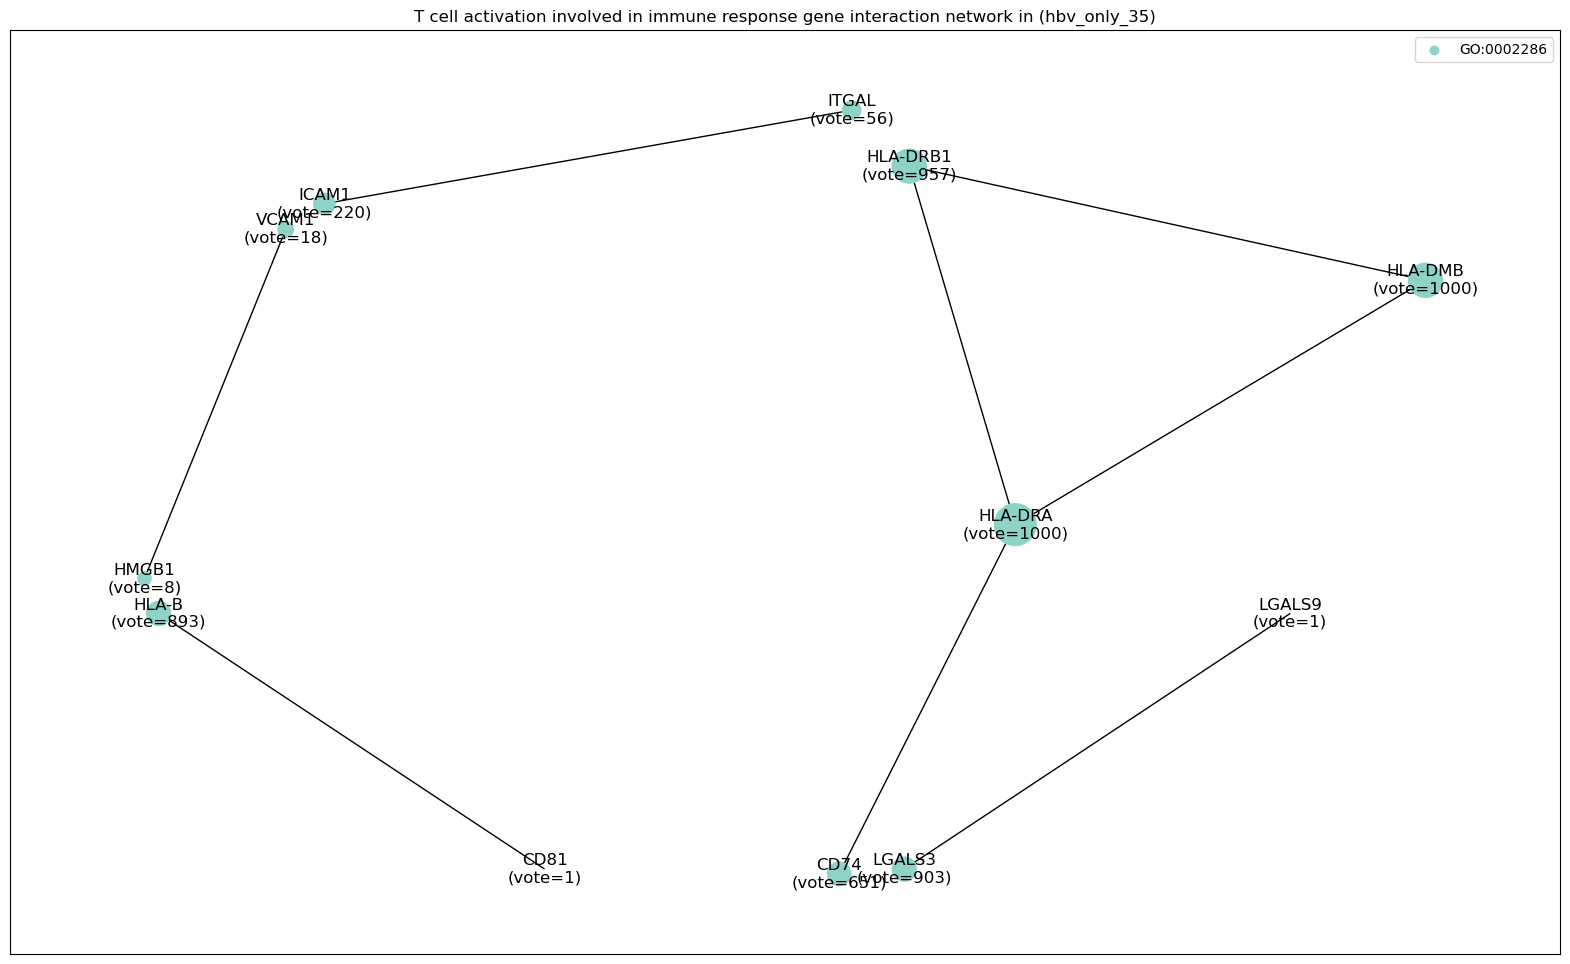

<Figure size 640x480 with 0 Axes>

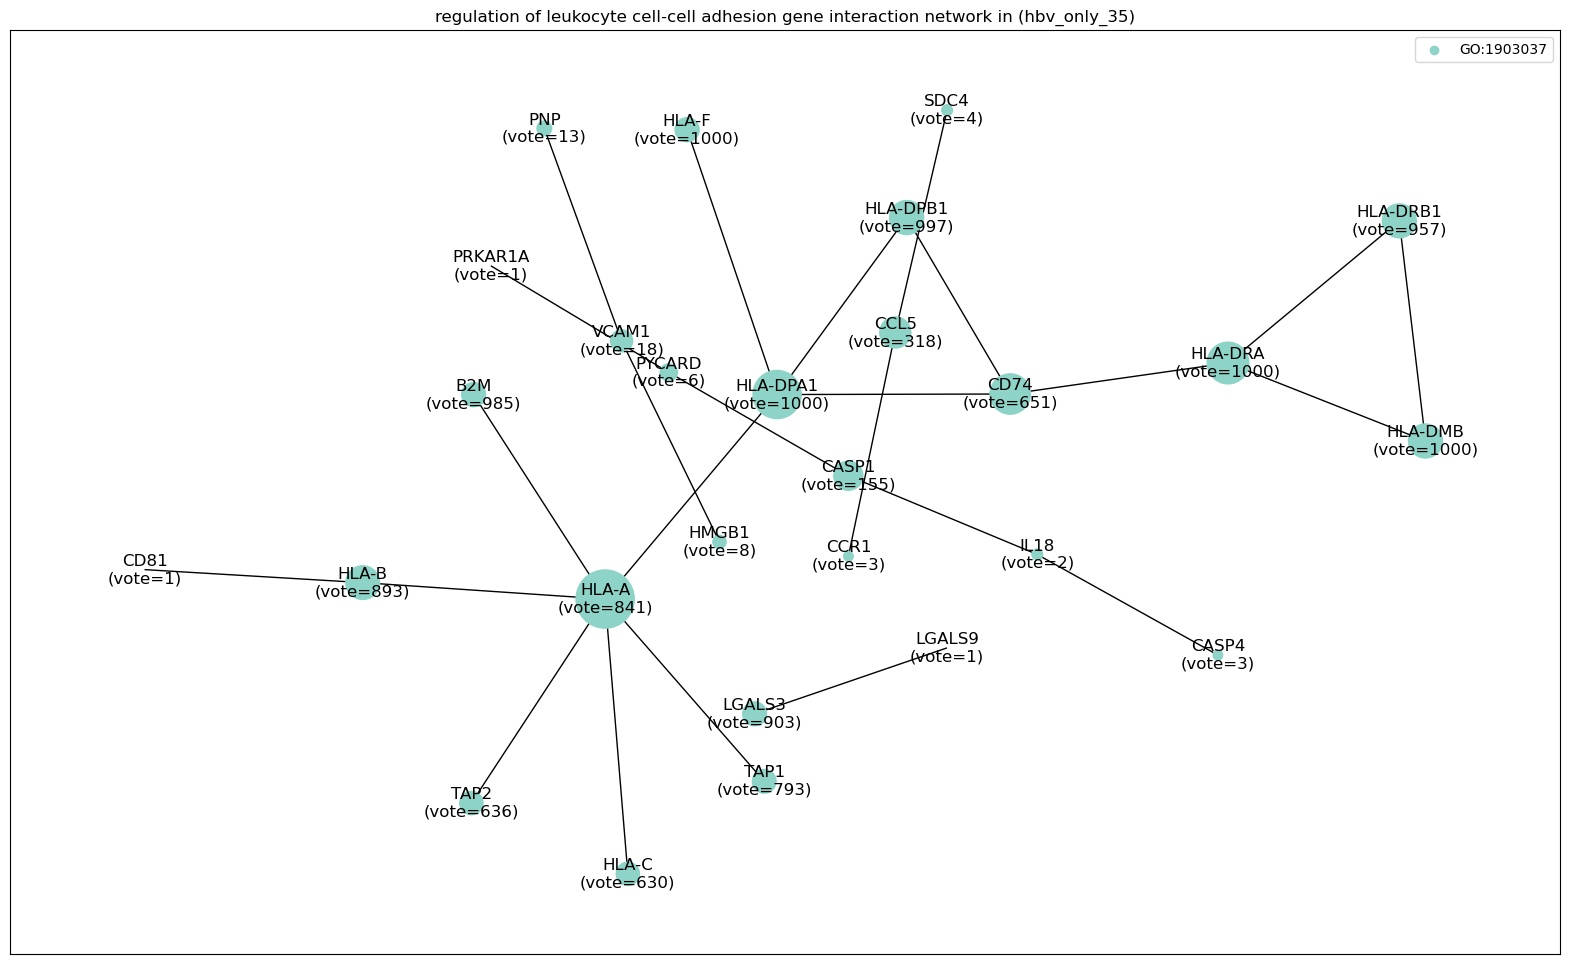

<Figure size 640x480 with 0 Axes>

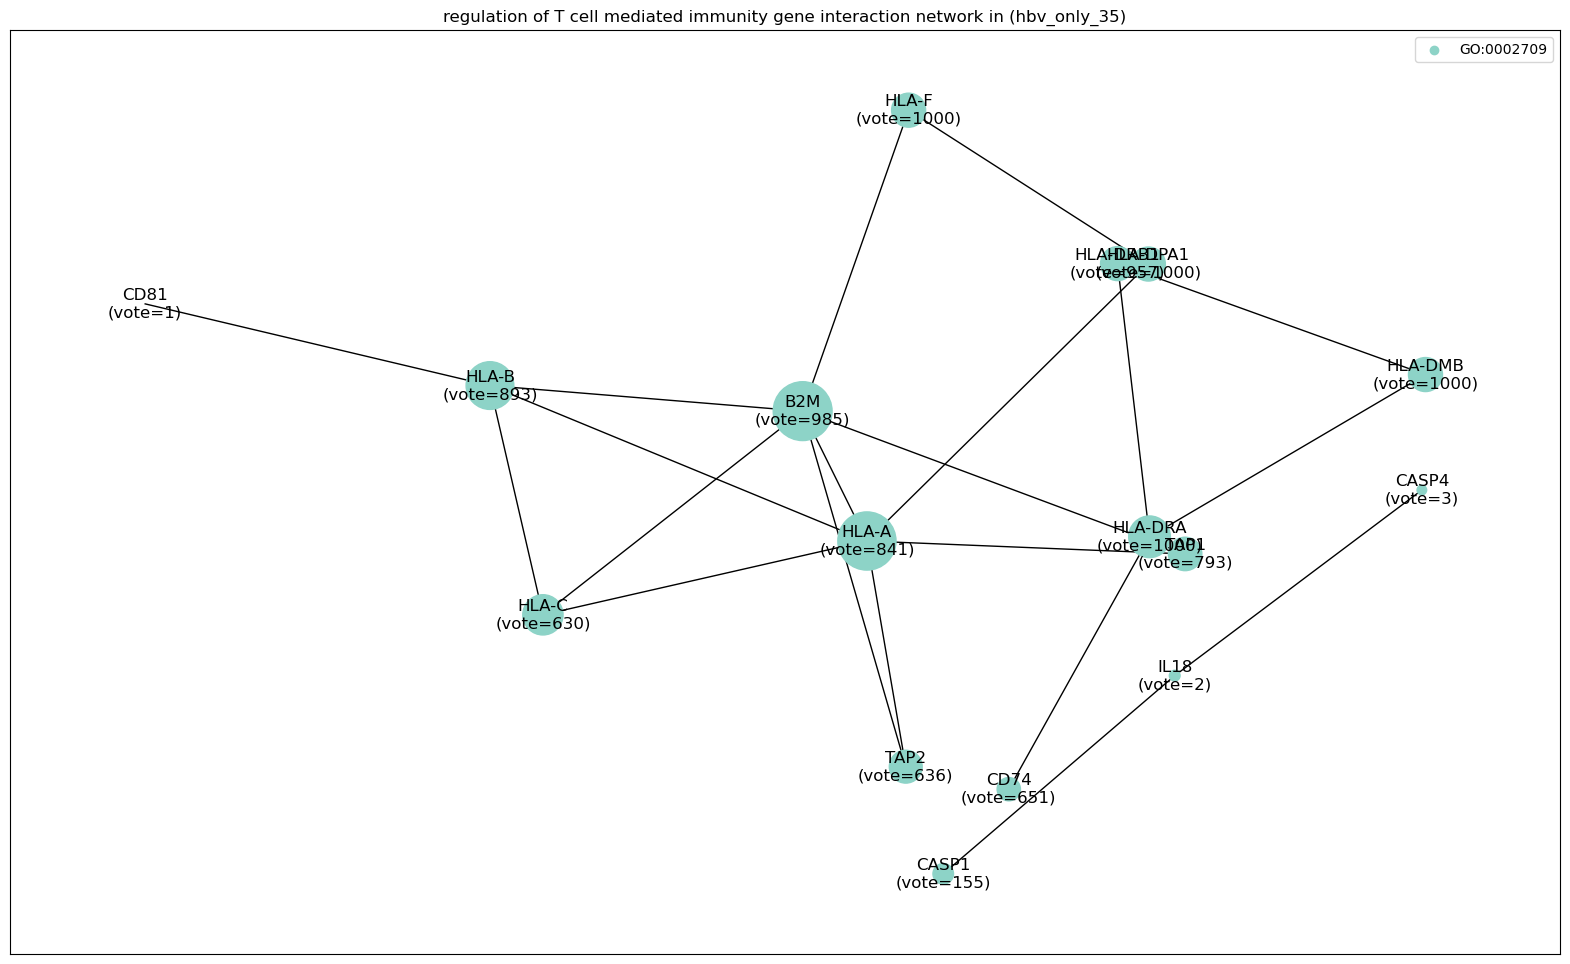

<Figure size 640x480 with 0 Axes>

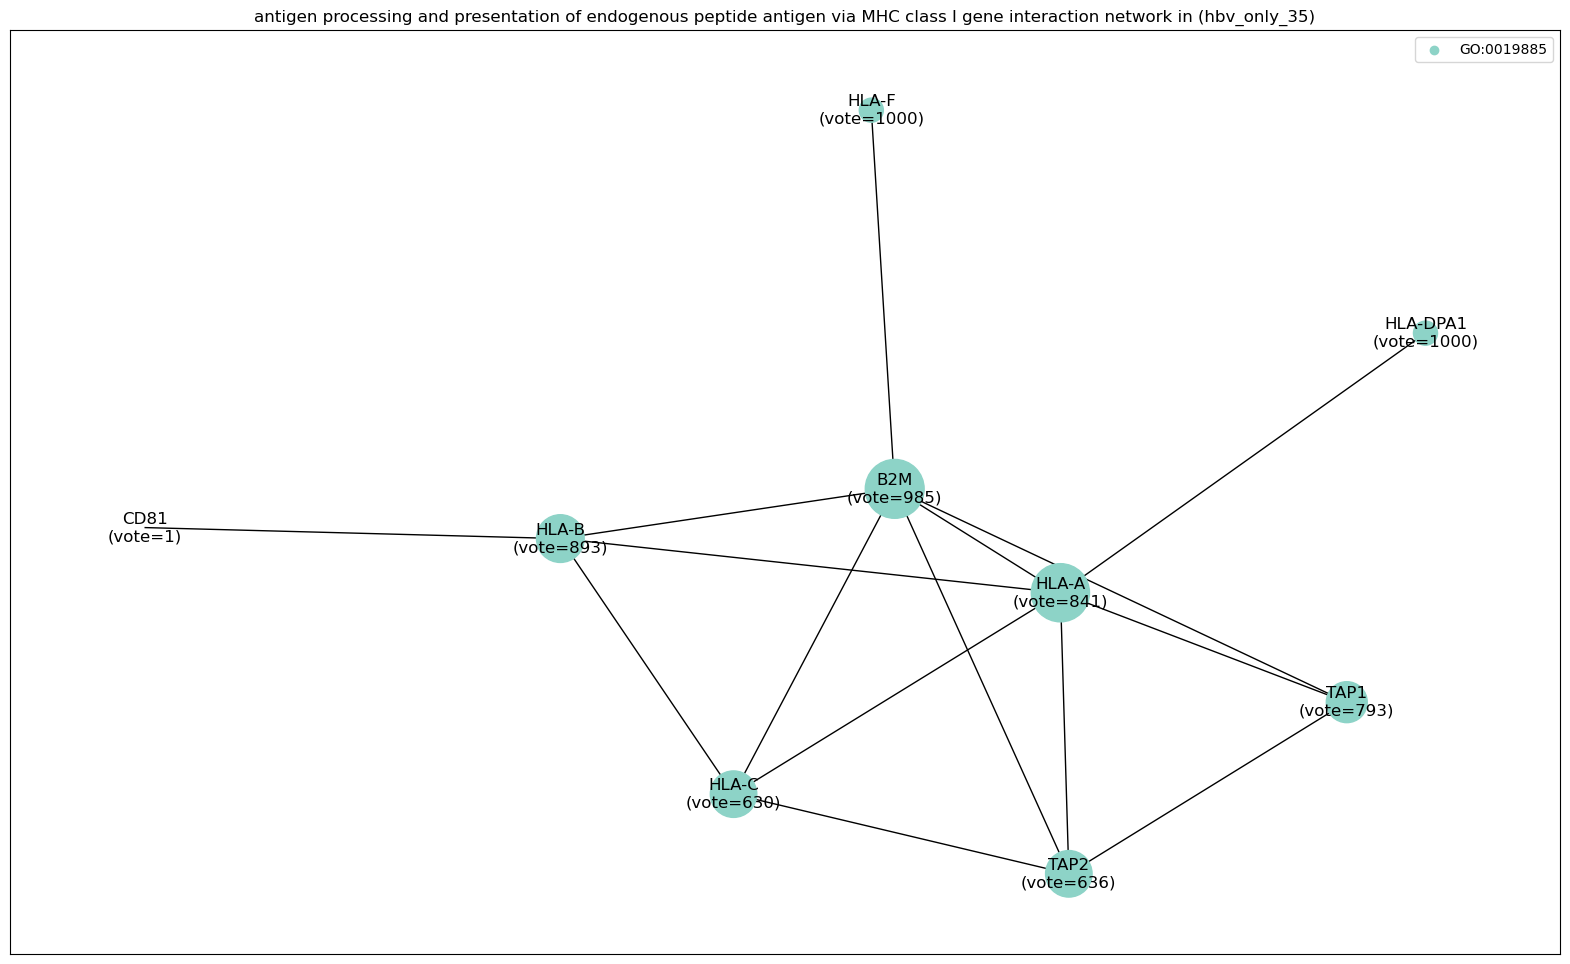

<Figure size 640x480 with 0 Axes>

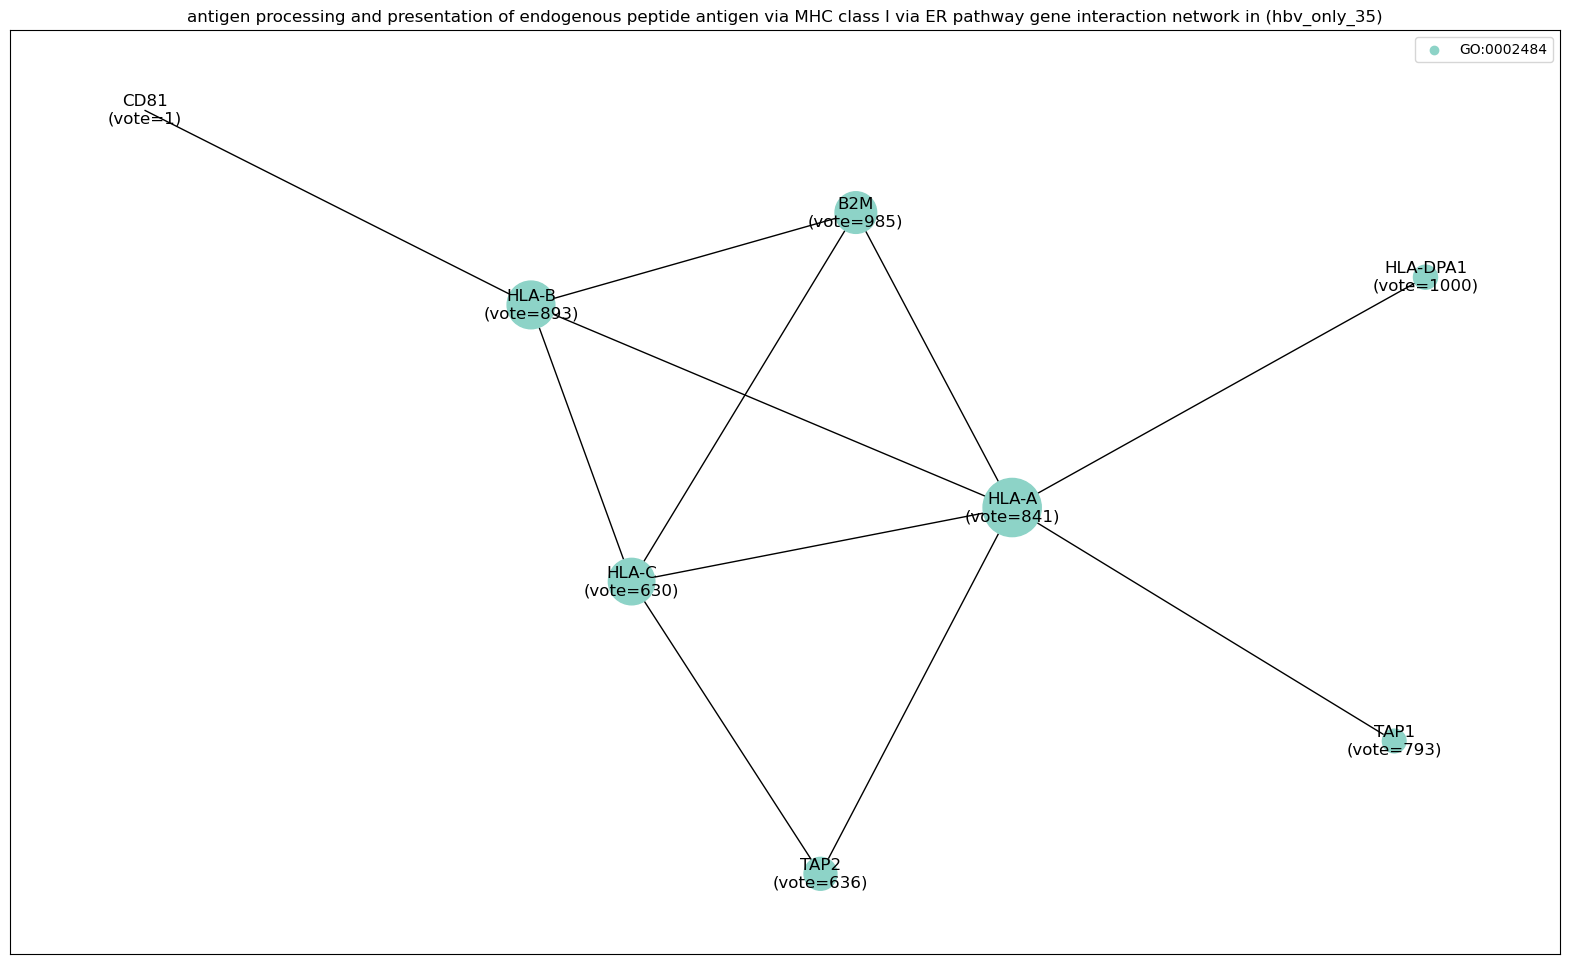

<Figure size 640x480 with 0 Axes>

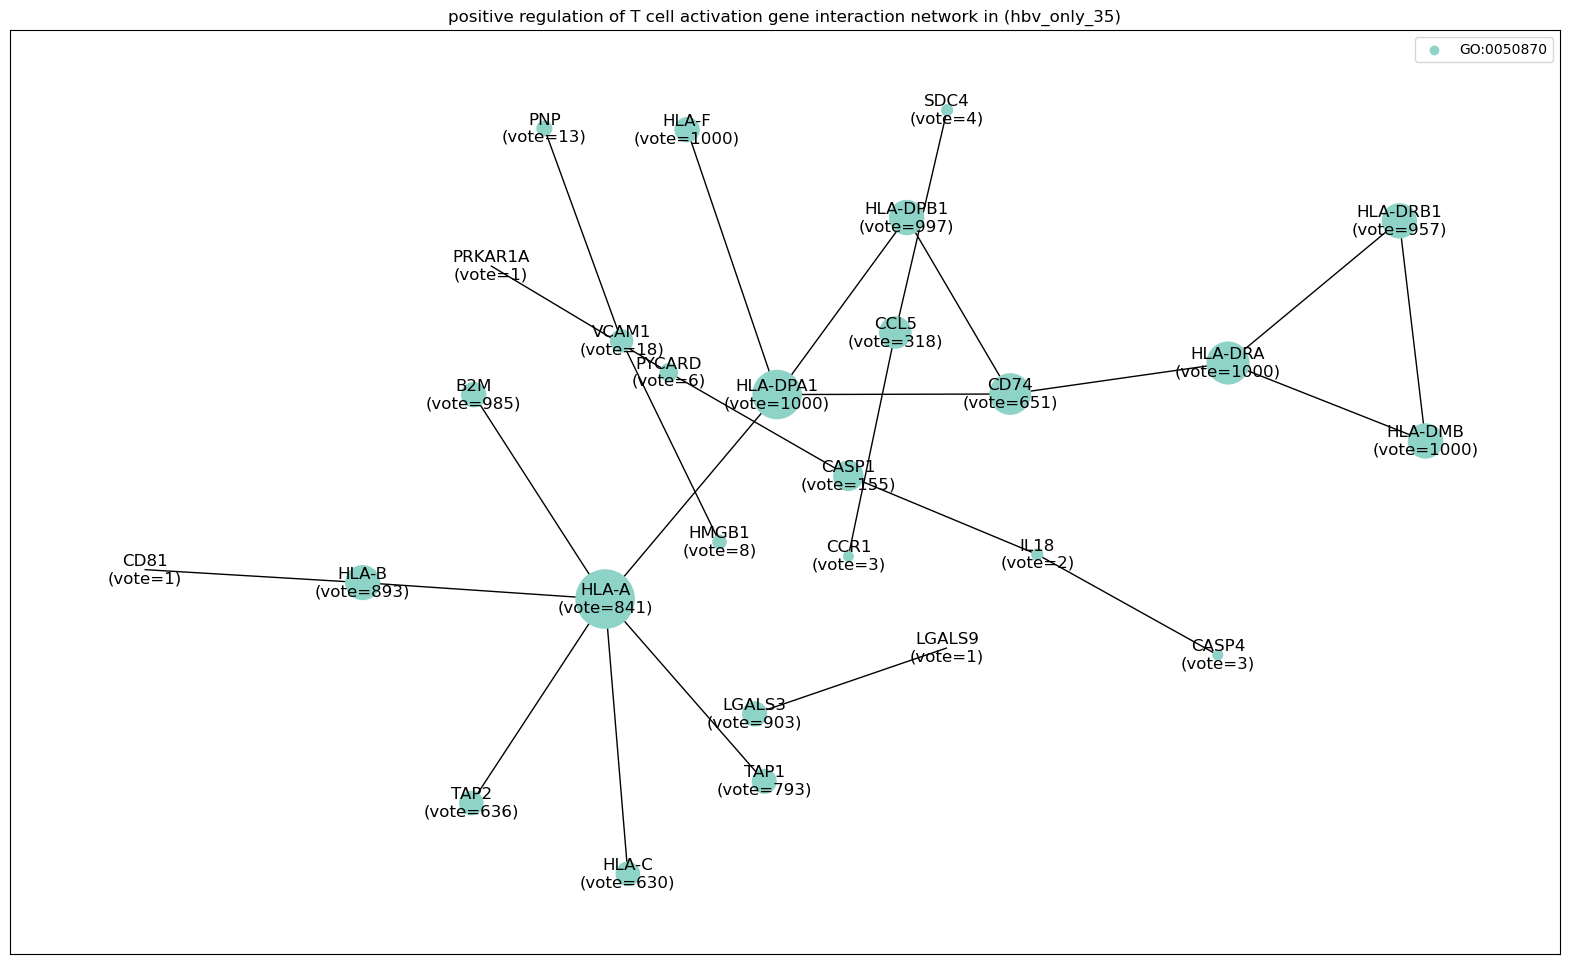

<Figure size 640x480 with 0 Axes>

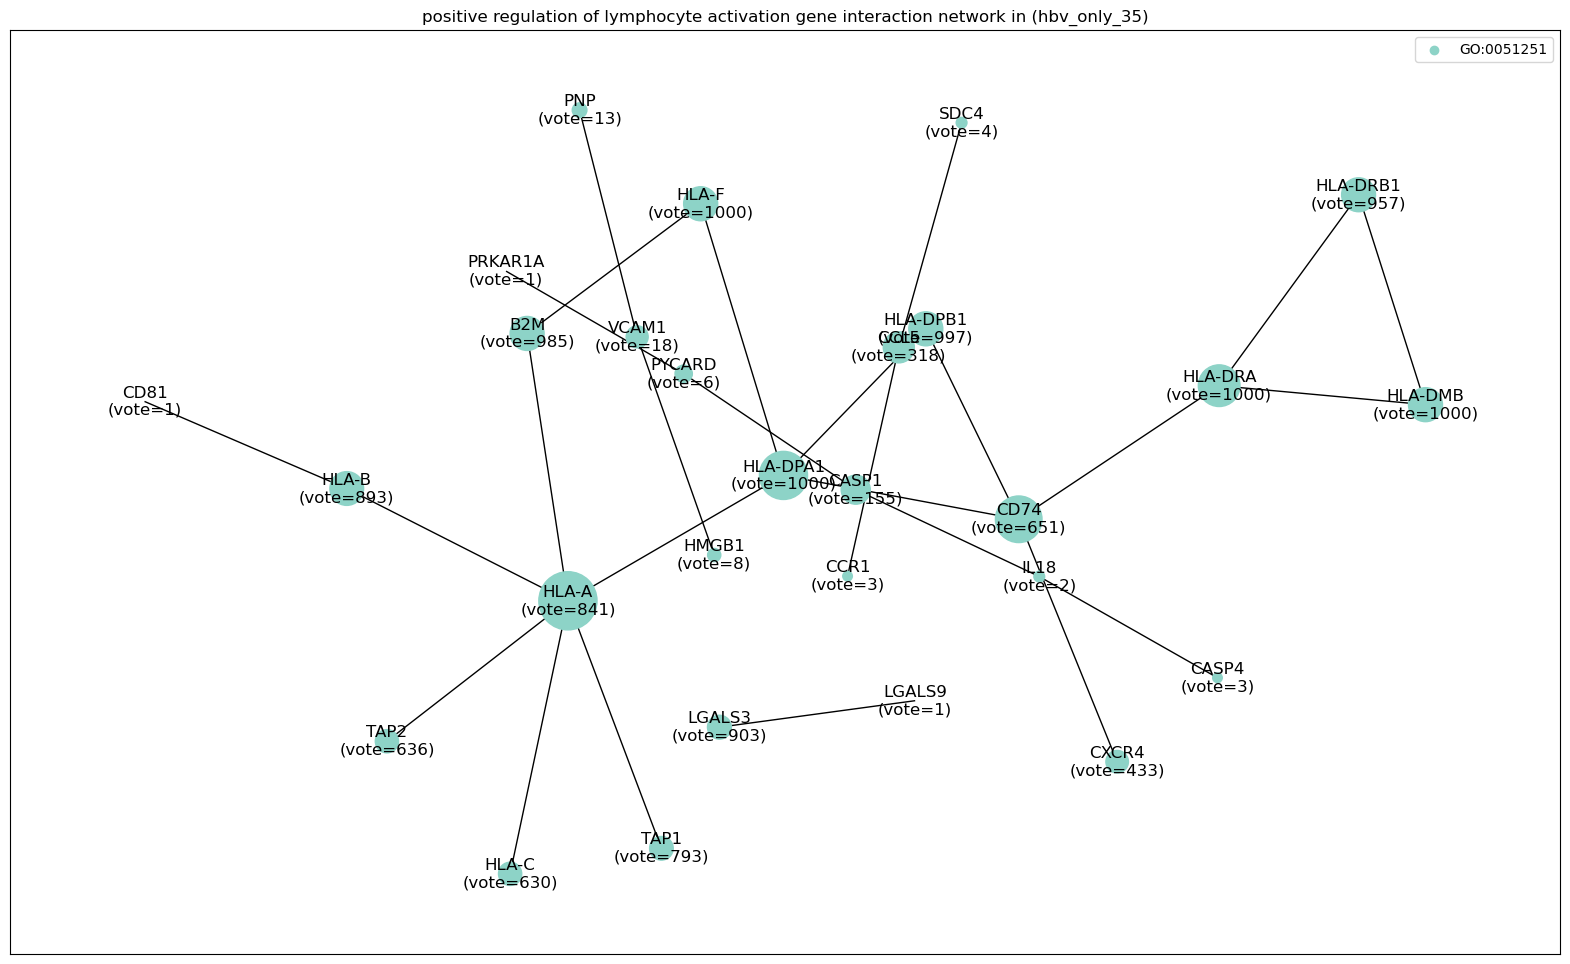

<Figure size 640x480 with 0 Axes>

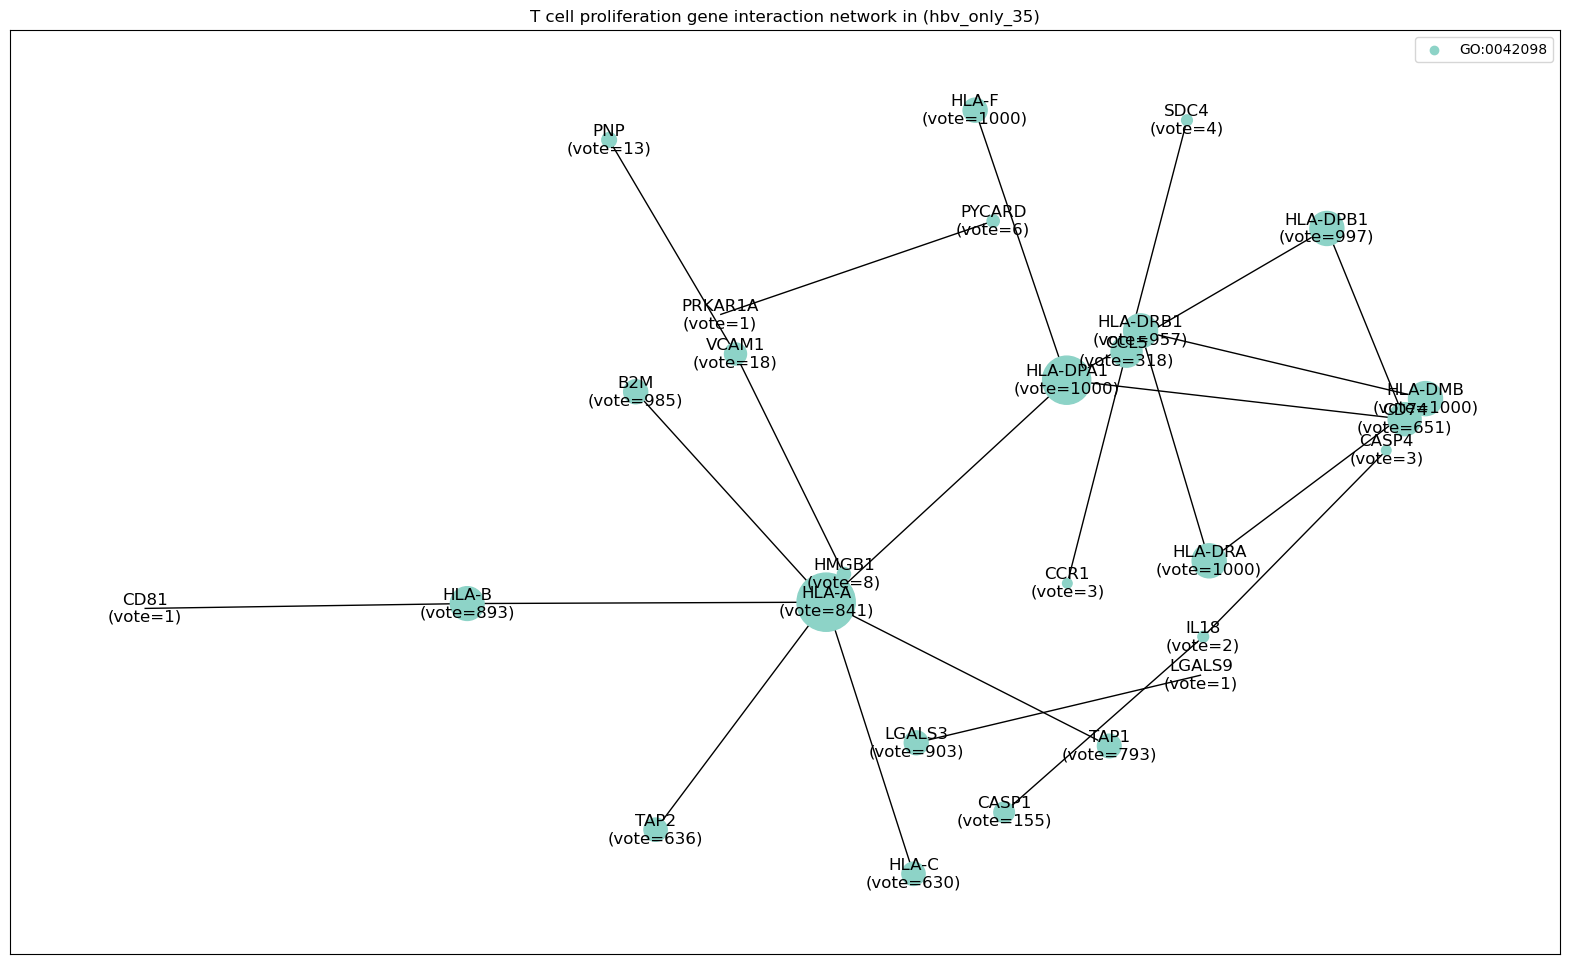

<Figure size 640x480 with 0 Axes>

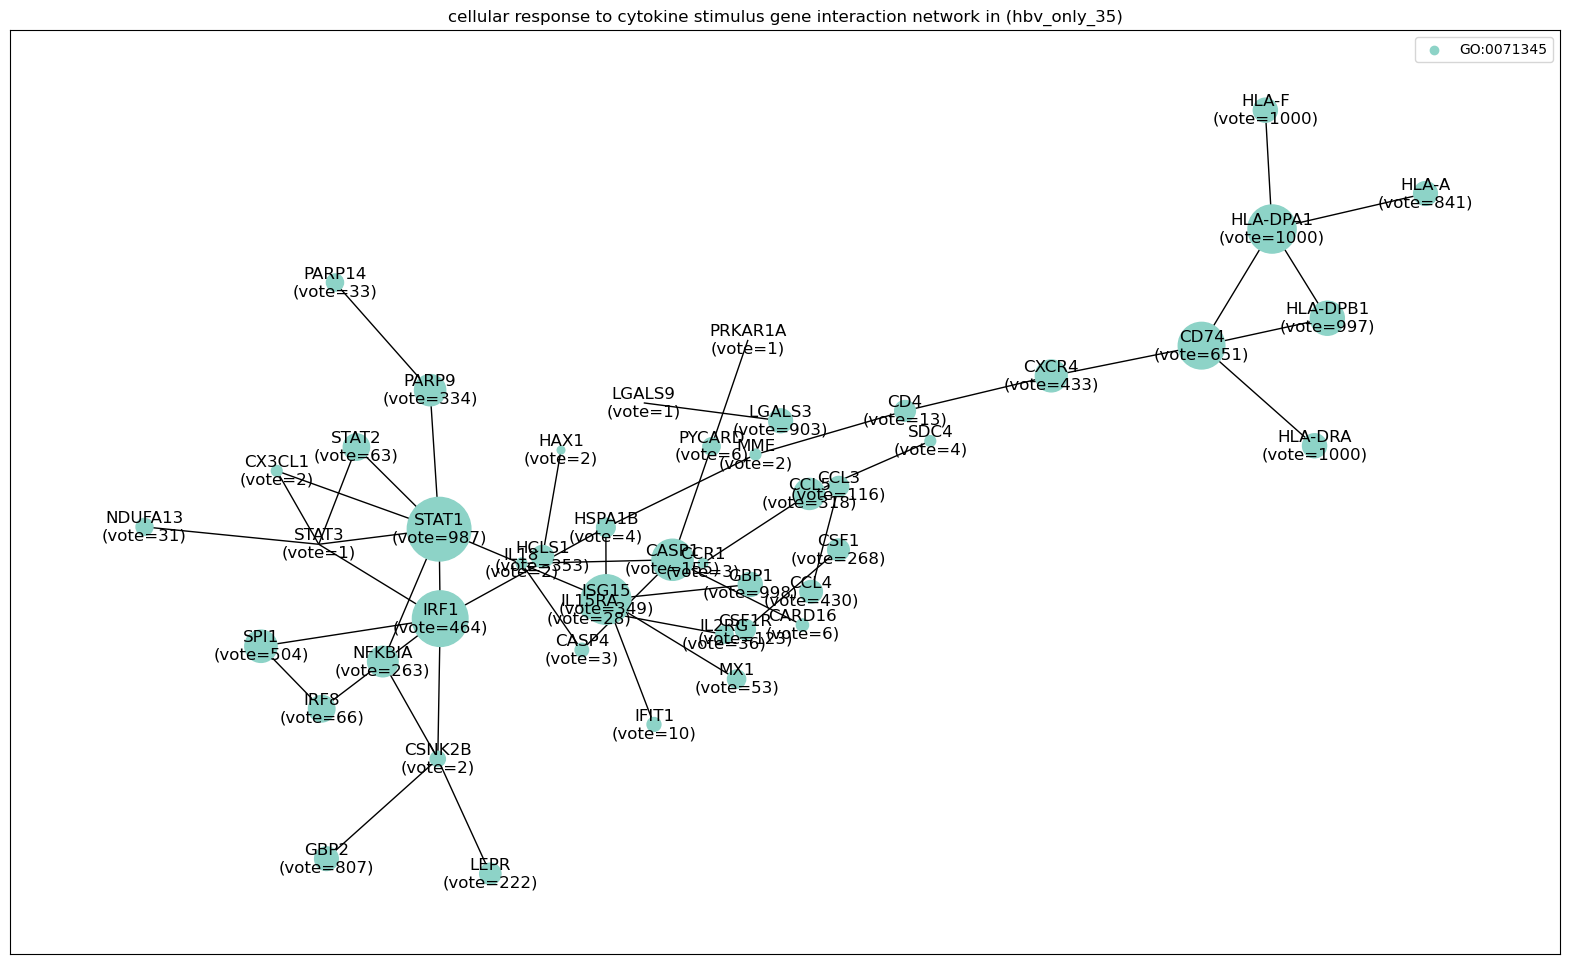

<Figure size 640x480 with 0 Axes>

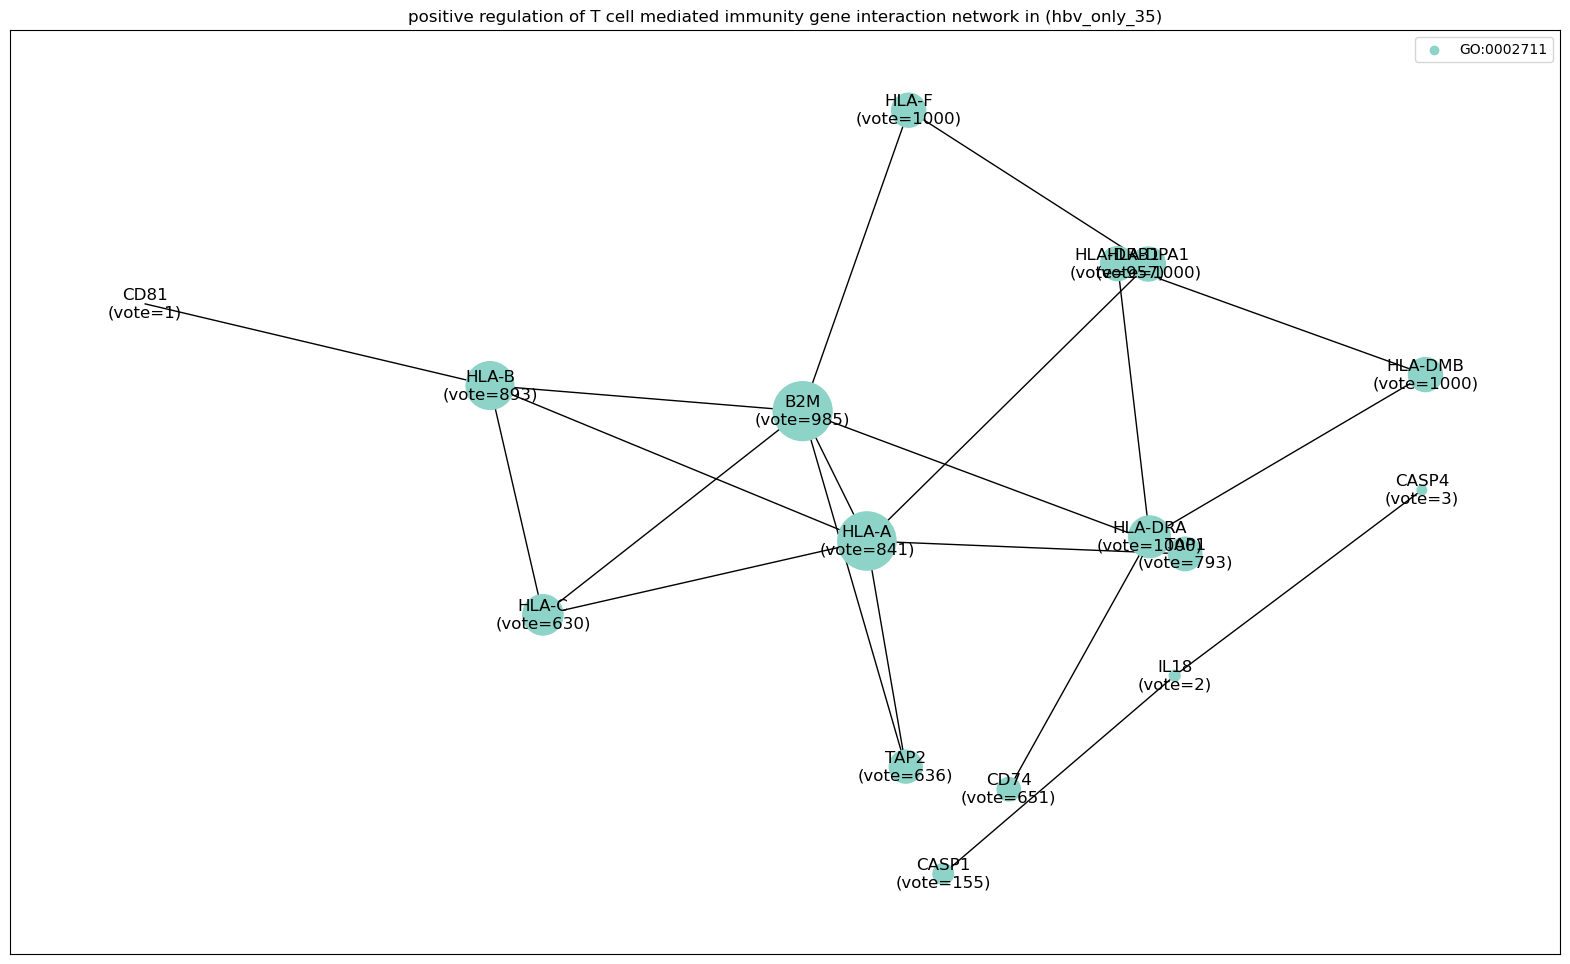

<Figure size 640x480 with 0 Axes>

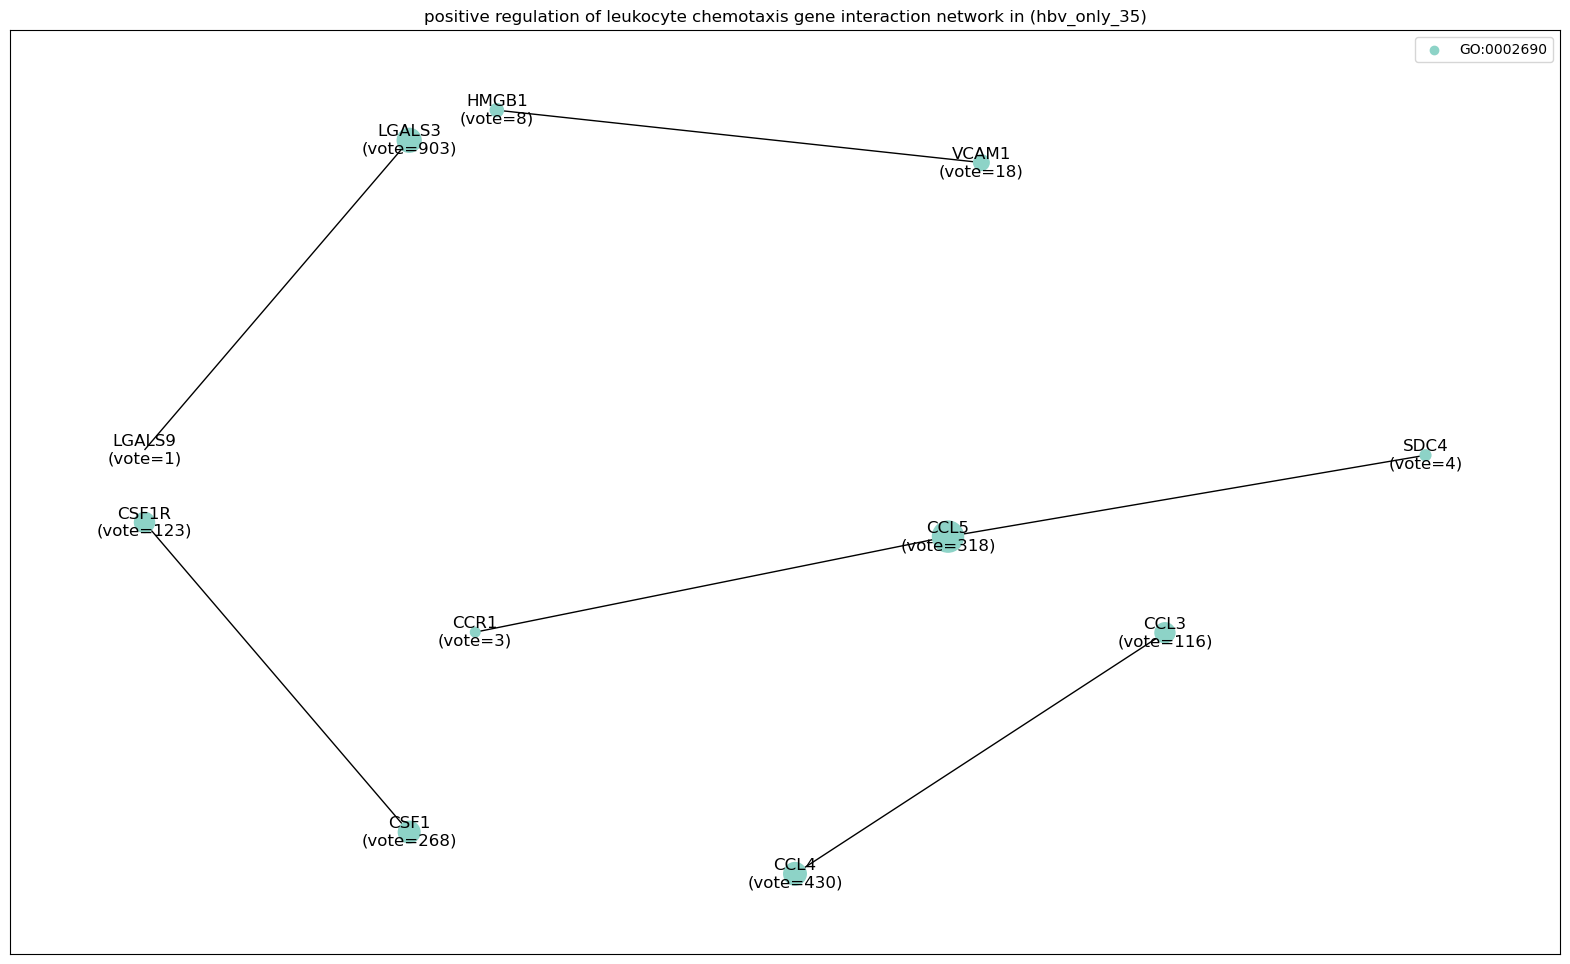

<Figure size 640x480 with 0 Axes>

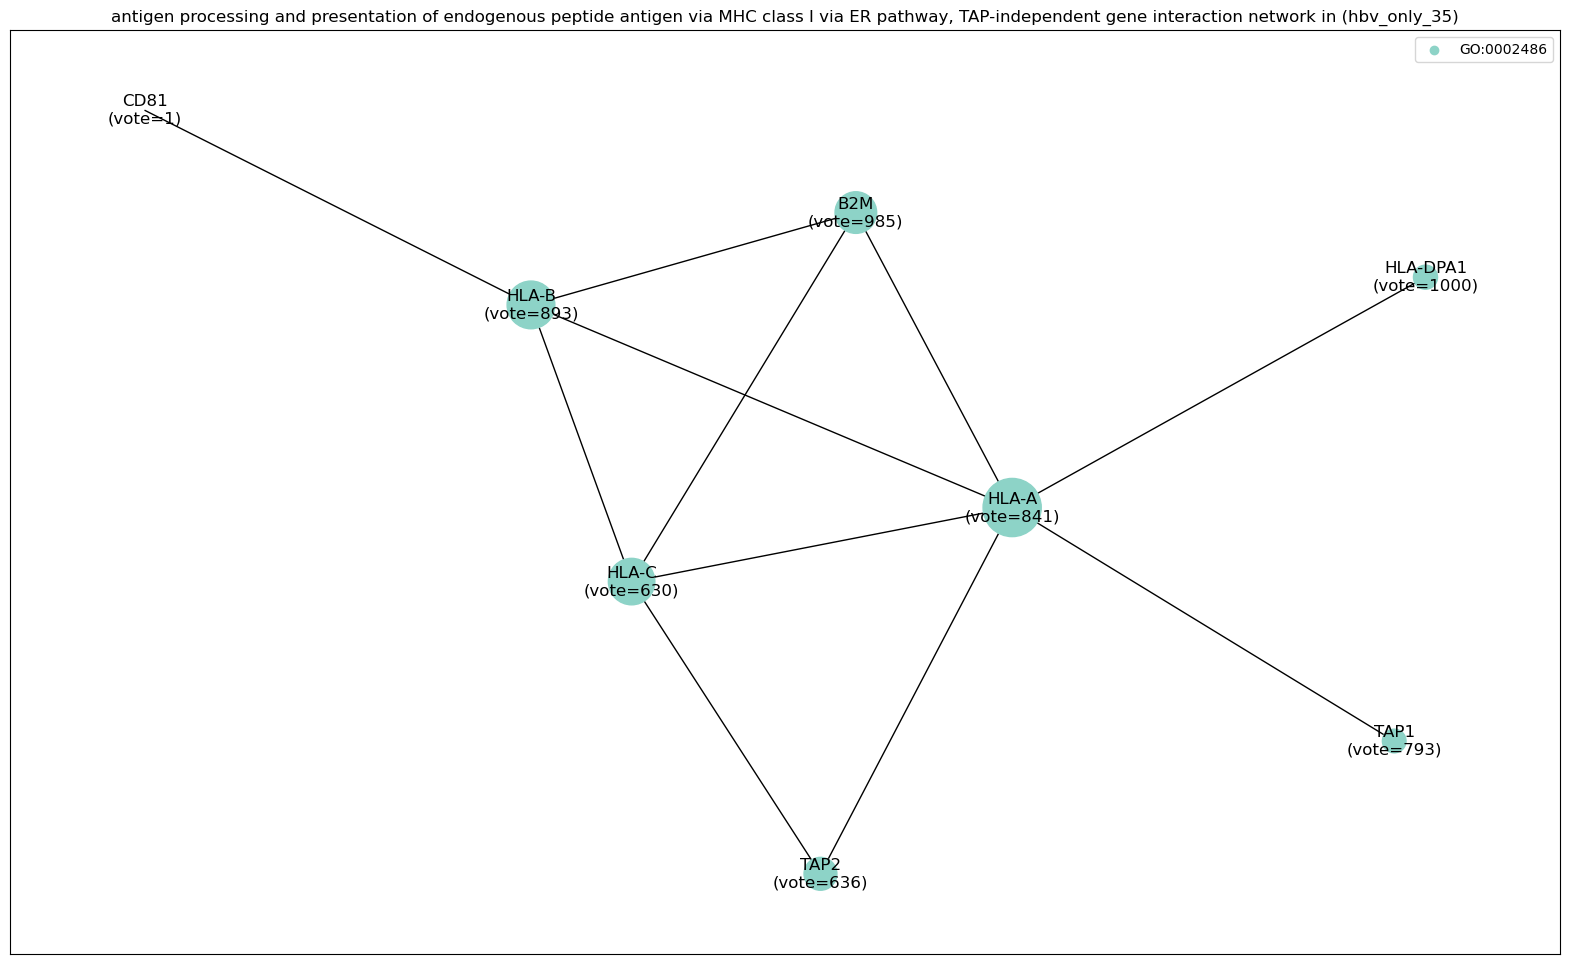

<Figure size 640x480 with 0 Axes>

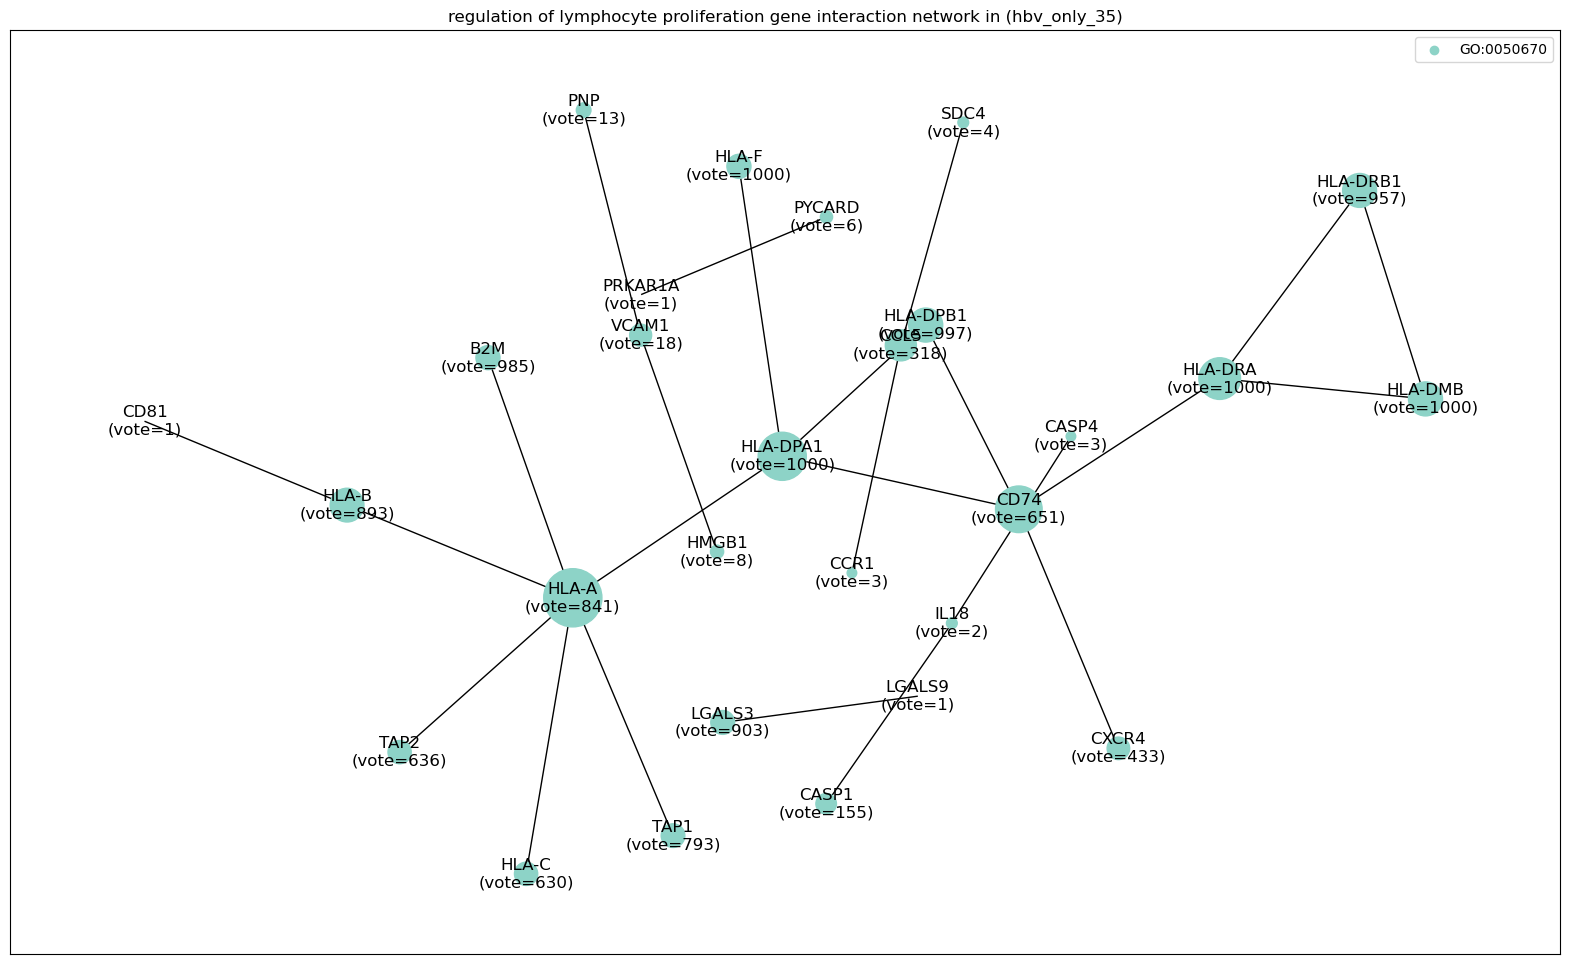

<Figure size 640x480 with 0 Axes>

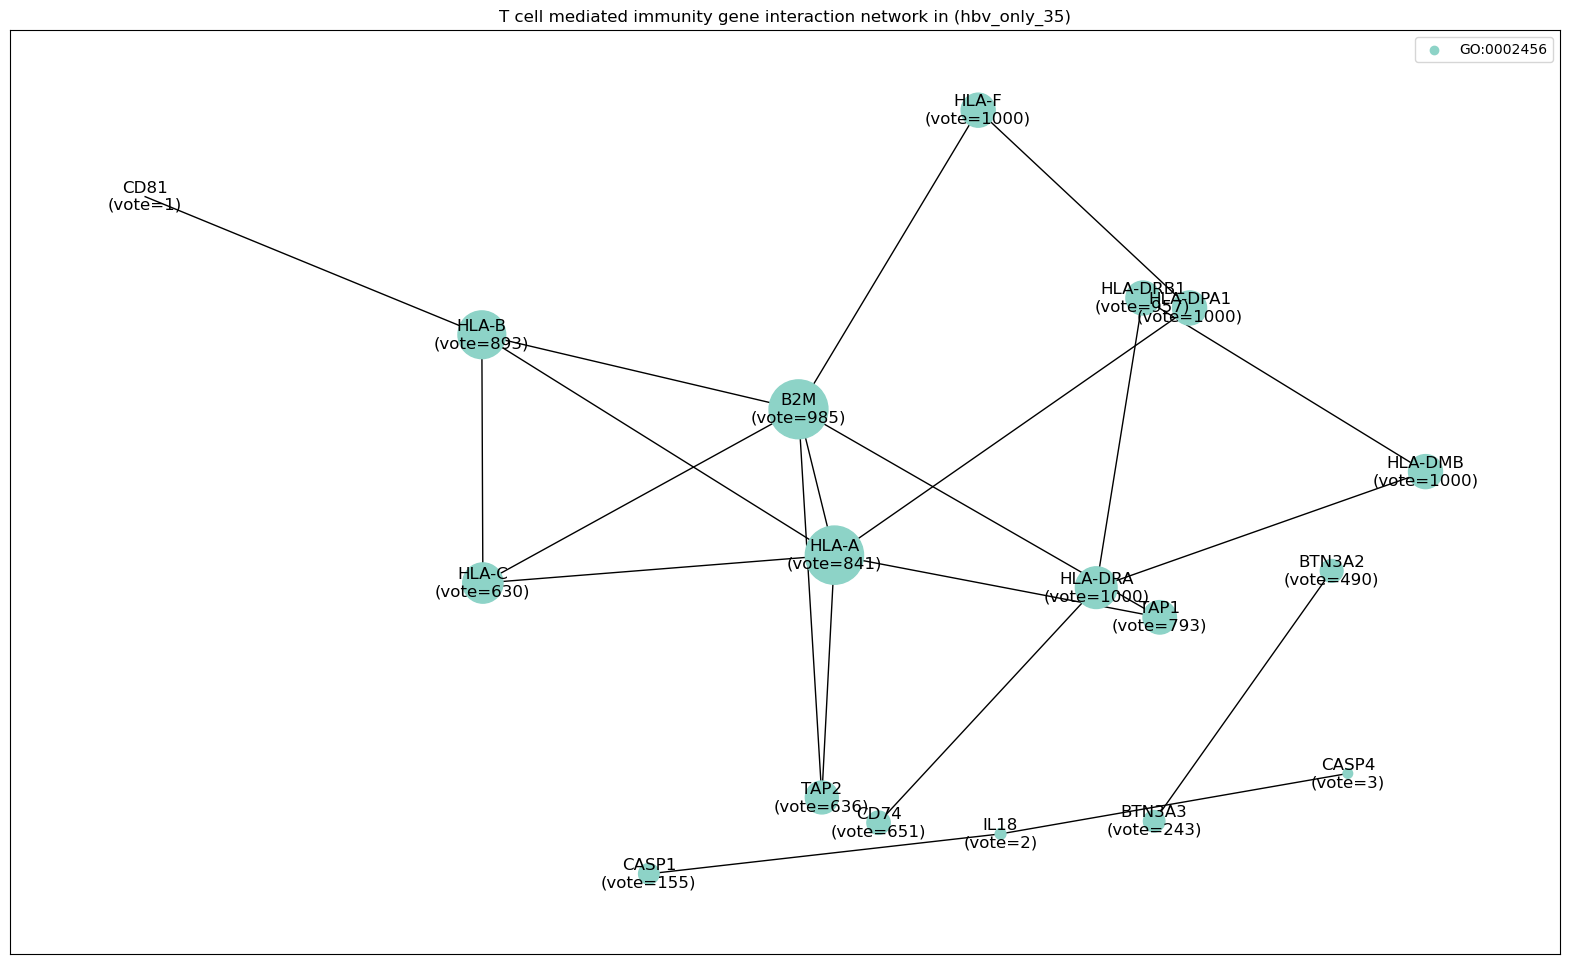

<Figure size 640x480 with 0 Axes>

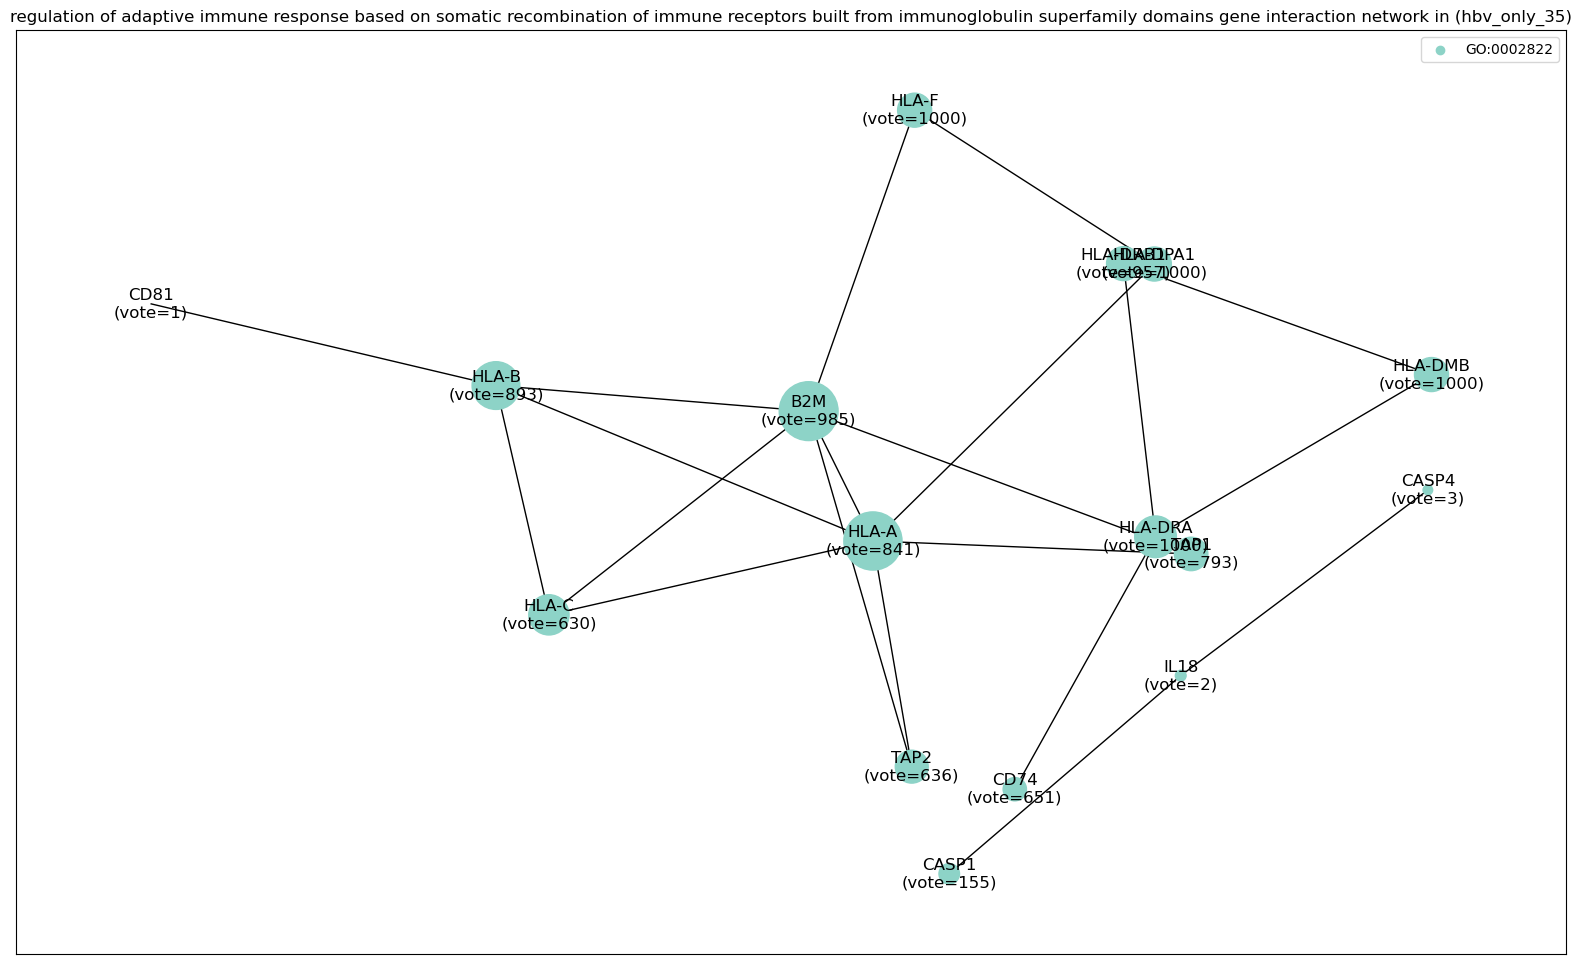

<Figure size 640x480 with 0 Axes>

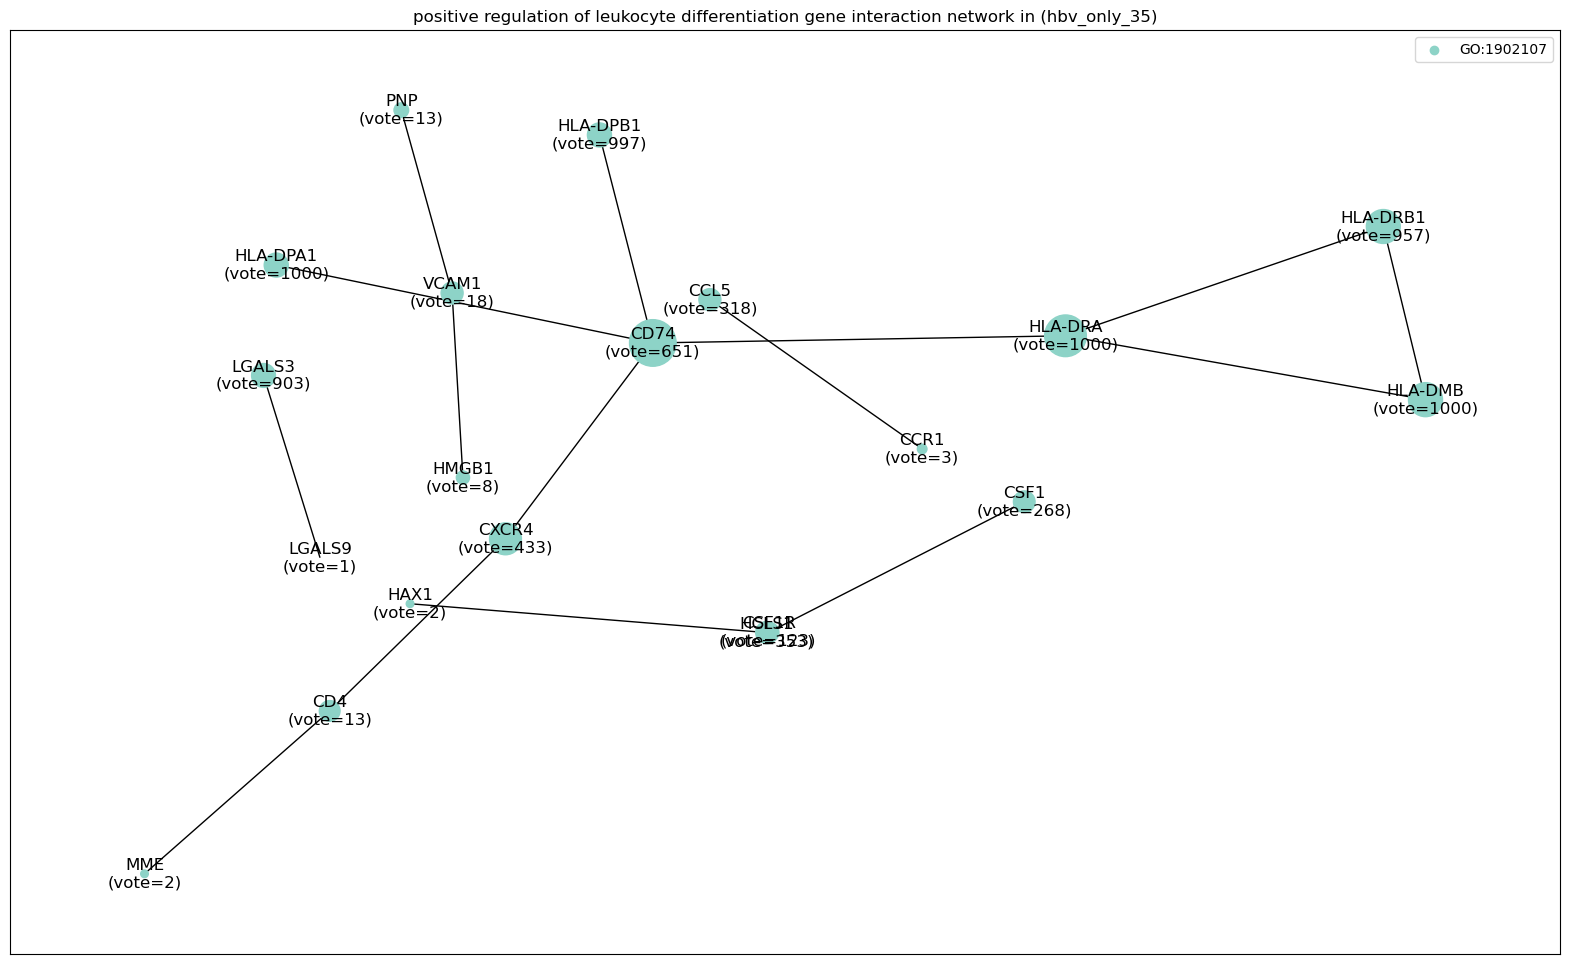

<Figure size 640x480 with 0 Axes>

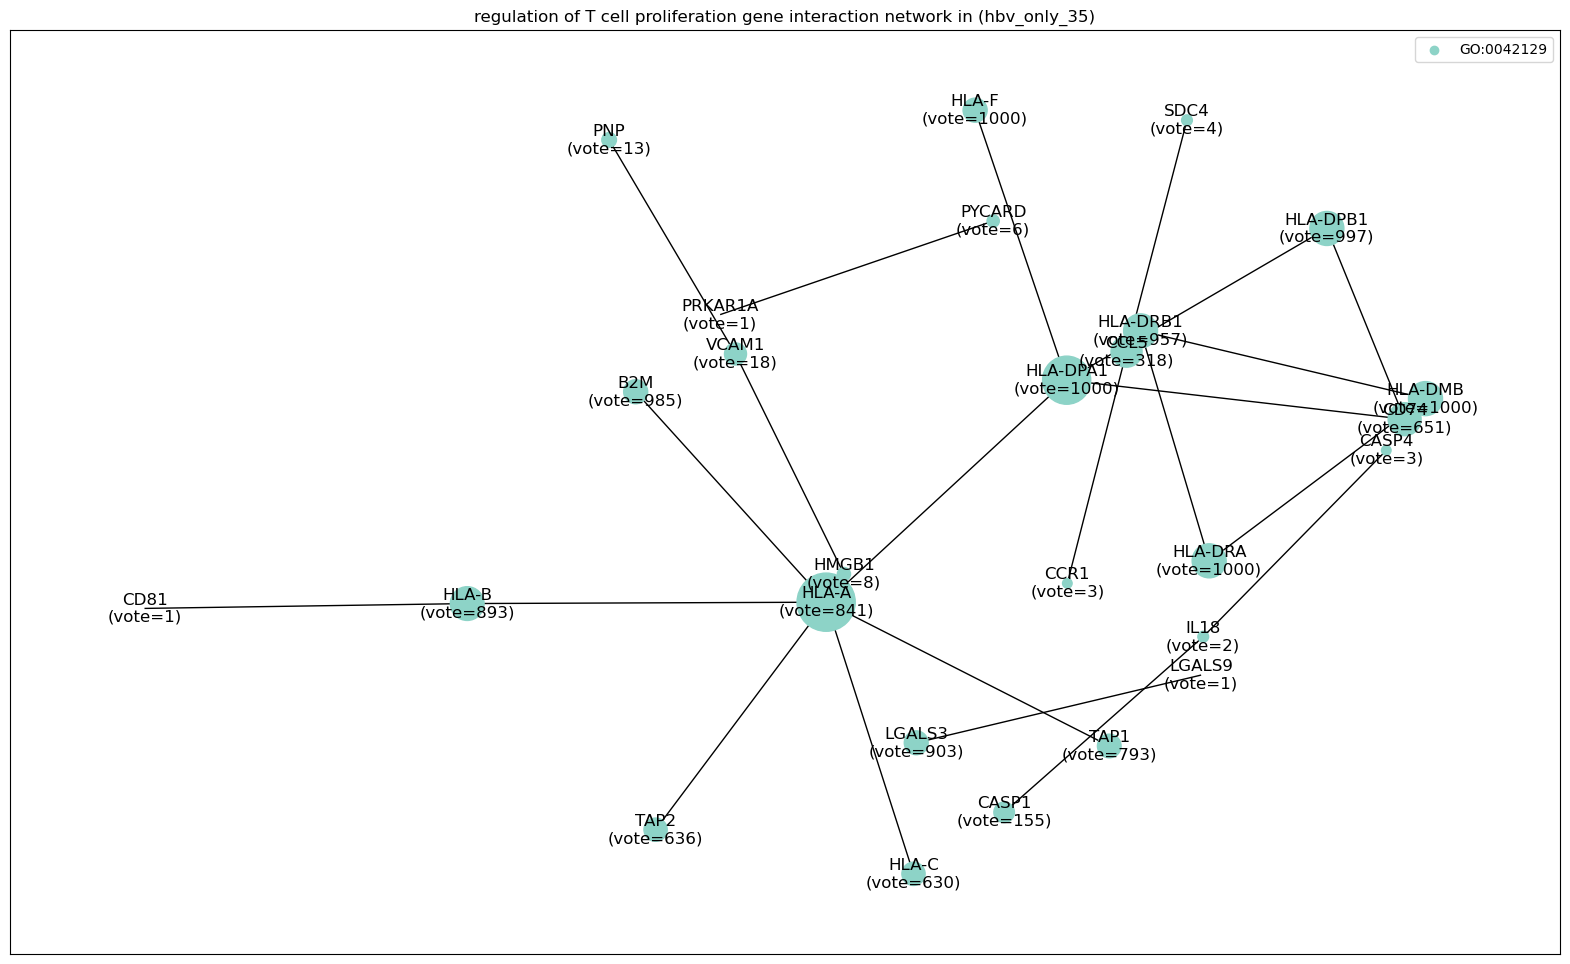

<Figure size 640x480 with 0 Axes>

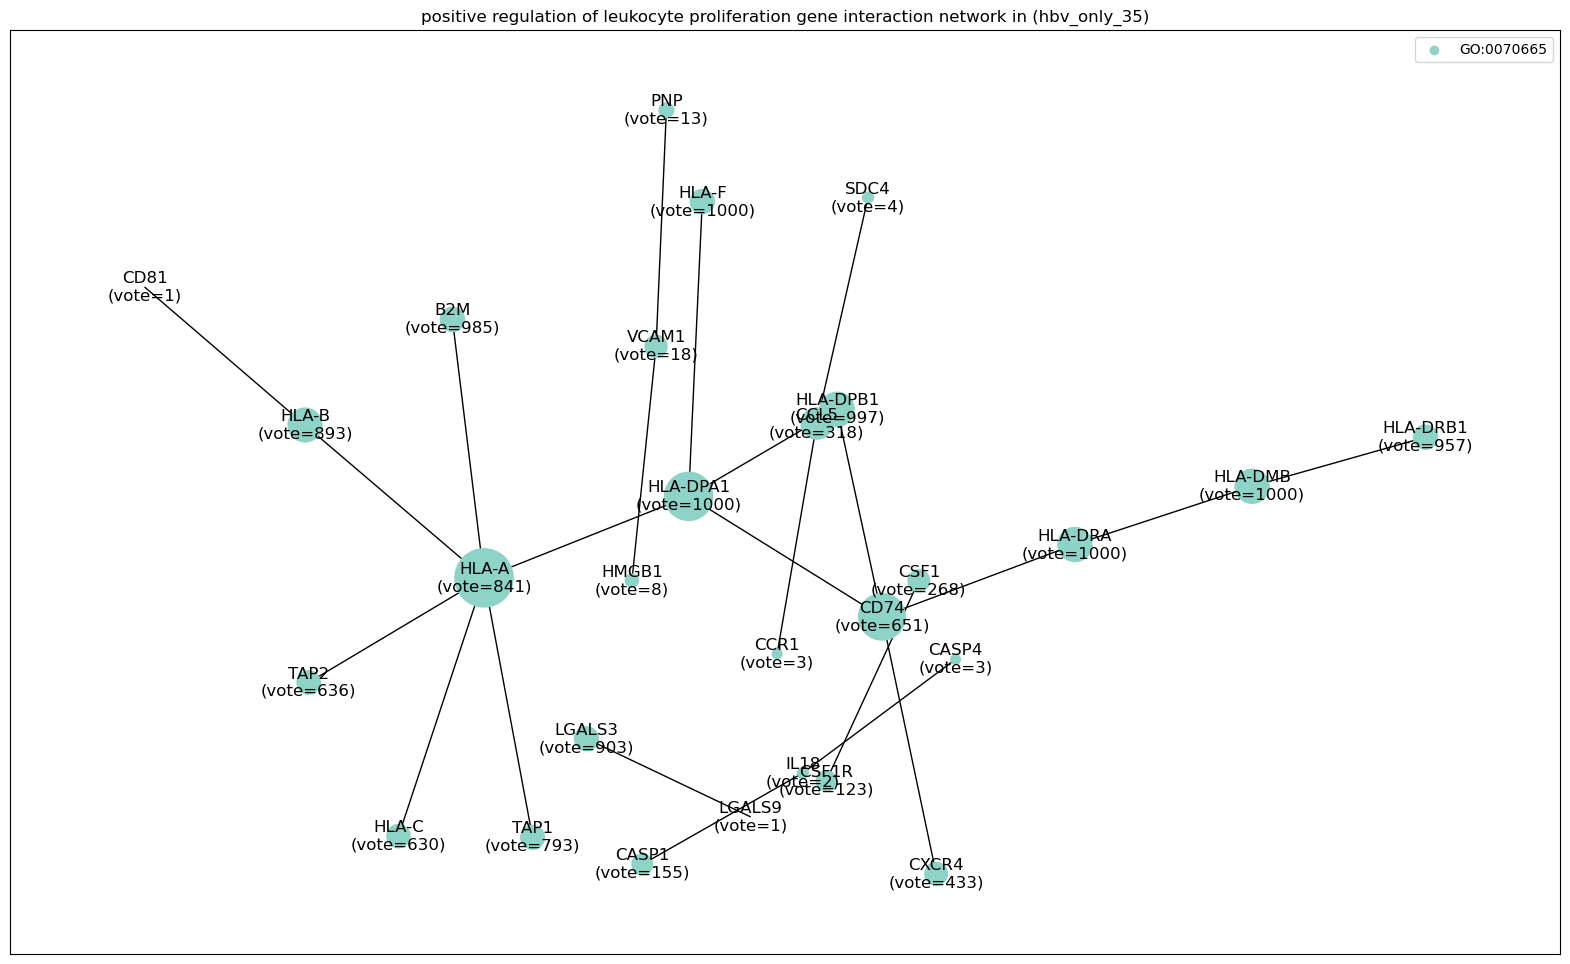

<Figure size 640x480 with 0 Axes>

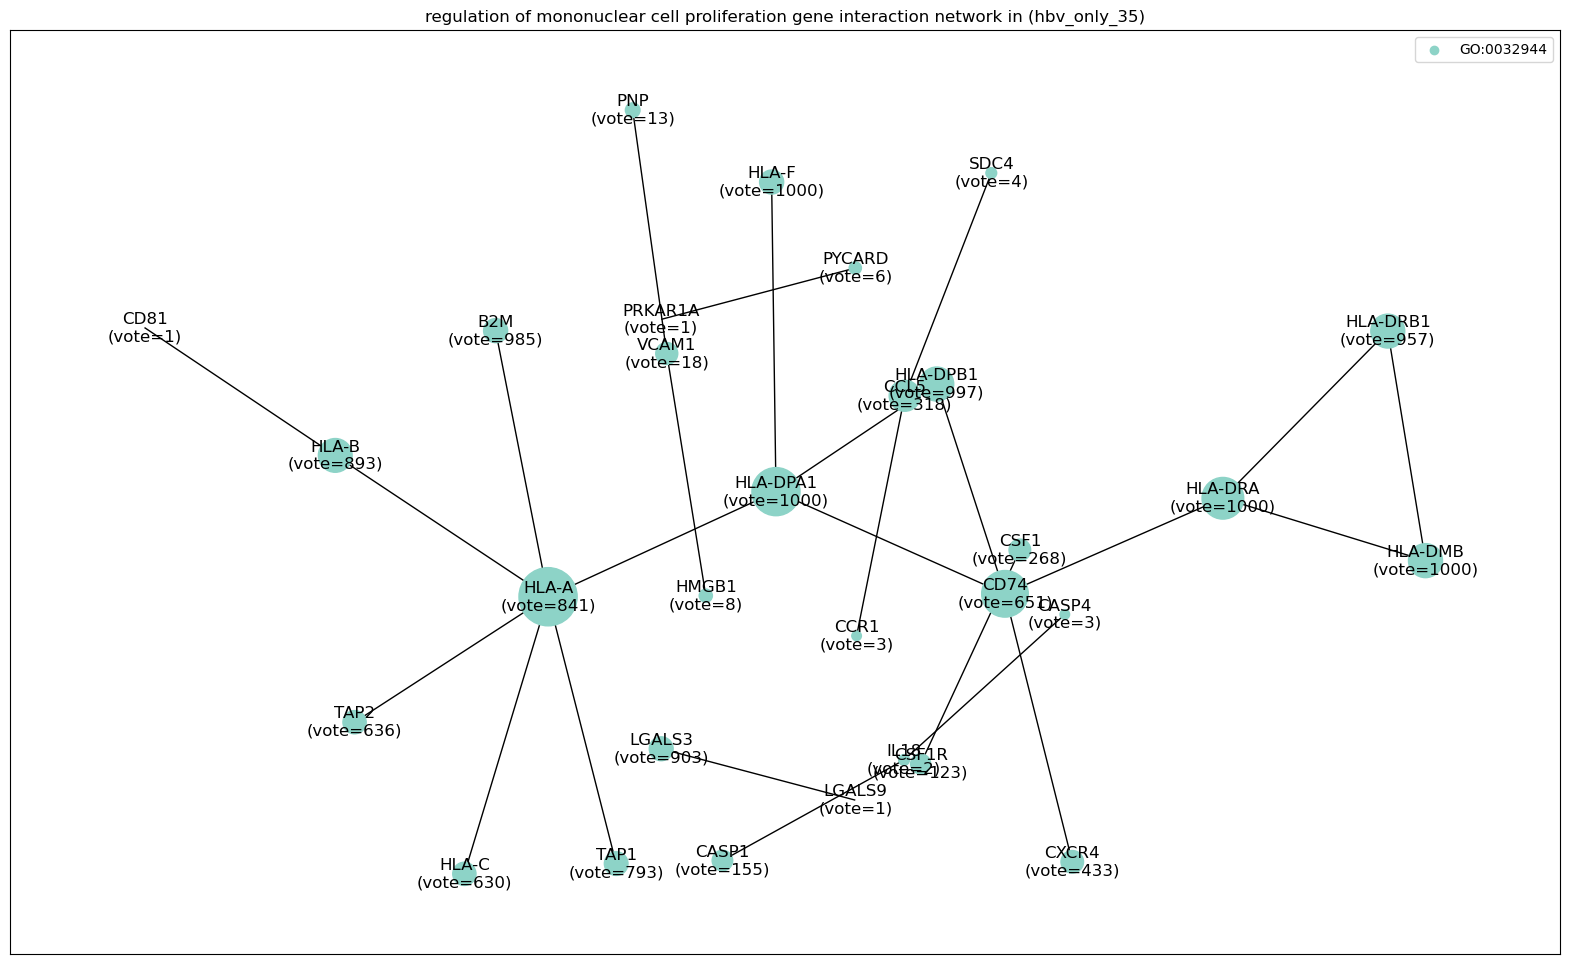

<Figure size 640x480 with 0 Axes>

In [13]:
module_network = construct_module_interaction_network(module_df,vote_result)
for go_idx,go in enumerate(module_df.GOID) :
    go_network = module_network.copy()
    description = module_df.Description[go_idx]
    nodes = module_df["Nodes"][module_df['GOID'] == go].values[0].split("_")
    remove_edges_without_candidate_gene(go_network,nodes)
    for node in go_network.nodes :
            go_network.nodes[node]['Description'] = go
    fig_go_path = repo_dir + "result/functional_module_interaction_network/%s_%s_%s_gene_interaction_network.pdf" % (ppi,sheet_name,description.replace(" ","-"))
    plot_gene_interaction_network(go_network,ens2hgsc,title="%s gene interaction network in (%s)" % (description,sheet_name),
                                    output_path=fig_go_path,
                                    hue='Description',
                                    weight='Vote',
                                    degree_threshold=0,
                                    fig_size=(20,12))
